In [1]:
import sys
stdout = sys.stdout
import re, math, nltk, datetime, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from cycler import cycler
import seaborn as sns
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
sys.stdout = stdout
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline


# configure pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

ModuleNotFoundError: No module named 'wordcloud'

In [7]:
# functions


is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords



The keywords_inventory function takes in the dataframe and analyzes the DESCRIPTION column:
* extracts proper and common names in each description
* extracts the root for each name, then aggregates all words that contain that root
* count the number of times each root appears
* select the shortest keyword as each root; thus, selecting singular if singular and plural present

In [2]:
# load wrangled retail df
ret= pd.read_csv('/home/jk/repos/predictive-segmentation/data/online_retail_II_wrangled.csv')
print(ret.shape)
ret.head()

(417534, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [3]:
products = pd.DataFrame(ret['Description'].unique()).rename(columns = {0:'Description'})
products.head(1)

,Description
0,15CM CHRISTMAS GLASS BALL 20 LIGHTS


In [8]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(products)

Number of keywords in variable 'Description': 1575


The execution of this function returns three variables:

* keywords: list of extracted keywords
* keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with each root
* count_keywords: dictionary listing the number of times every word is used


In [11]:
# create list of lists of products and sort by number of occurences
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)
list_products[:5]

[['pink', 259], ['heart', 235], ['candle', 213], ['set', 197], ['glass', 193]]

In [18]:
list_products[-5:]

[['chives', 1], ['thyme', 1], ['parsley', 1], ['desk', 1], ['mop', 1]]

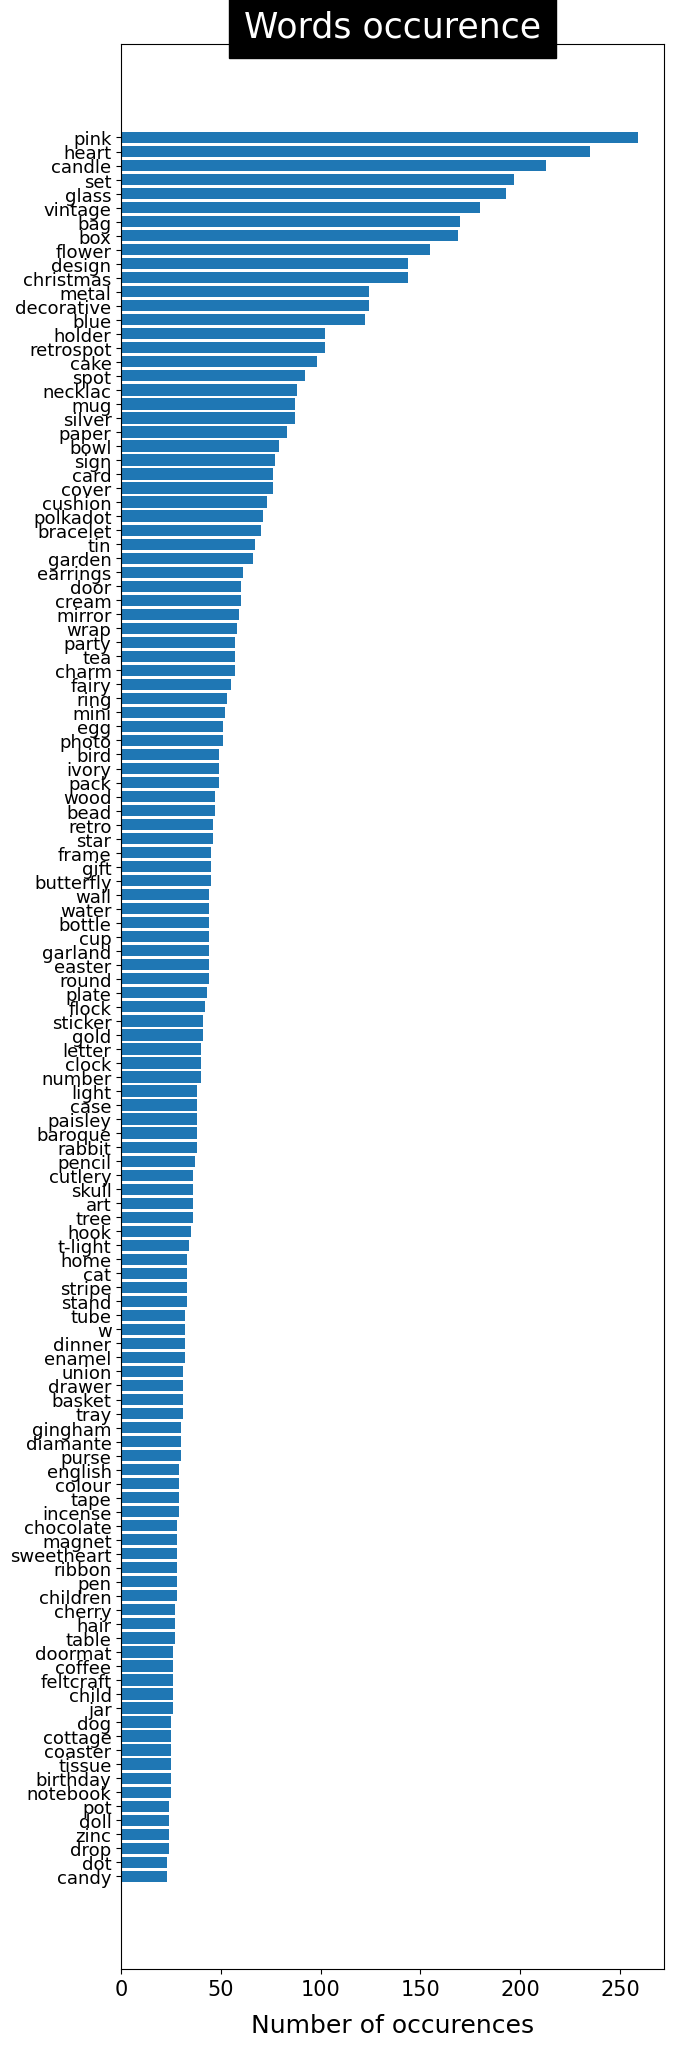

In [13]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

There are >1500 words, and some are colors that offer little product information. So, those are discarded and only keywords occuring 10 or more times are included

In [39]:
print('Number of keywords appearing once: {}'.format(kw_counts.count(1)))
cutoff = 10
kw_below_cutoff = sum(i<cutoff for i in kw_counts)
print('Number of keywords appearing less than {}: {}'.format(cutoff, kw_below_cutoff))

Number of keywords appearing once: 611
Number of keywords appearing less than 10: 1277


In [40]:
# remove useless keywords and those occuring less than 10 times
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < cutoff: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Number of keywords used:', len(list_products))

Number of keywords used: 283


In [42]:
ret_cleaned = pd.read_csv('/home/jk/repos/predictive-segmentation/data/online_retail_II_w-cleaned.csv')
descriptions = ret_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occur_count in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), descriptions))

/tmp/ipykernel_2081/4053434447.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), descriptions))
/tmp/ipykernel_2081/4053434447.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), descriptions))
/tmp/ipykernel_2081/4053434447.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

/tmp/ipykernel_2081/4053434447.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), descriptions))
/tmp/ipykernel_2081/4053434447.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), descriptions))
/tmp/ipykernel_2081/4053434447.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

The $X$ matrix indicates the words contained in the description of the products using the one-hot-encoding principle. Introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [45]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(descriptions):
    prix = ret_cleaned[ ret_cleaned['Description'] == prod]['Price'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1



In [46]:
print("{:<8} {:<20} \n".format('range', 'number products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number products      
--------------------
0<.<1       928                 
1<.<2       1162                
2<.<3       848                 
3<.<5       708                 
5<.<10      583                 
.>10        215                 


In [48]:
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.08441057422418122
For n_clusters = 4 The average silhouette_score is : 0.10754709660938924
For n_clusters = 5 The average silhouette_score is : 0.12447375093971977
For n_clusters = 6 The average silhouette_score is : 0.12227070460279262
For n_clusters = 7 The average silhouette_score is : 0.10867774183622347
For n_clusters = 8 The average silhouette_score is : 0.12621023529351919
For n_clusters = 9 The average silhouette_score is : 0.12728014094164808


The silhouette scores for models with >4 clusters are roughly eqiuvalent. 5 clusters was chosen as with higher number of clusters some clusters only contained a few samples. Thus, the product segmentation model with 5 clusters offers the best balance of performance and parsimony. 